### Time series Data Analysis using ARIMA model.
(ARIMA)Auto Regressive Integrated Moving Average is a class of models that explains
a given time series based on its own past values, i.e , its own lags and the lagged forecast errors,
so that equation can be used to forecast future values

### Problem statement
Given Monthly time series data of number of passengers in flight predict the number of passengers in next month


Importing libraries

In [805]:
import numpy as np
import pandas as pd
from functools import reduce
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from scipy.special import erfinv

Importing dataset

In [806]:
def dateparse(dates): return pd.datetime.strptime(dates, '%Y-%m')
dataset = pd.read_csv('./Data/AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)

In [807]:
dataset.head(4)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129


Visualize the data

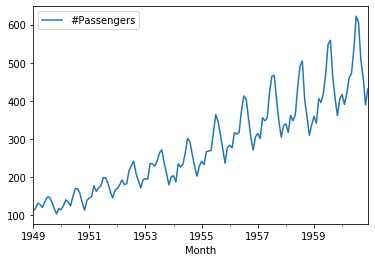

In [808]:
dataset.plot()

We can see clearly there is increasing trend but formally we can check stationarity by using Dickey-Fuller Test

### Perform Augumented Ducky Fuller test to check for stationarity
#### It determine the presence of unit root in the series
<li>Null Hypothesis: The series has a unit root (value of a =1)
<li>Alternate Hypothesis: The series has no unit root.
<br>
Unit root indicates that the statistical properties of a given series are not constant with time
<br>
    let for some time series :<br/>
    <b>y<sub>t</sub> = a*y<sub>t-1</sub> + ε<sub>t</sub></b><br/>
    <b>y<sub>t-1</sub> = a*y<sub>t-2</sub> + ε<sub>t</sub><br/></b>
    for all observations, the value of yt will come out to be:<br/>
    <b>y<sub>t</sub> = a<sup>n</sup>*y<sub>t-n</sub> + Σε<sub>t-i</sub>*a<sup>i</sup><br/></b>
    If the value of a is 1 (unit) in the above equation, then the predictions will be equal to the y<sub>t-n</sub> and sum of all errors from t-n to t, which means that the variance will increase with time. This is knows as unit root in a time series and for a stationary time series, the variance must not be a function of time.<br/>
    If the test statistic is less than the critical value, we can reject the null hypothesis (means the series is stationary). else we fail to reject the null hypothesis (The series is not stationary).

In [809]:
"""return boolean whether dataset is stationary from Augumented Ducky Fuller method test pass or not"""
def adf_test(data, critical_val=None, verbose=False):
    testres = adfuller(data, autolag='AIC')
    # order Test Statistic, p-value, number of Lags Used,Number of Observations Used, critial val.
    test_statistic = testres[0]
    if verbose :
        print('test statistic:- {0}\np-value:- {1}\nnumber of Lags Used:- {2}\nNumber of Observations Used:- {3}'.
             format(test_statistic, testres[1], testres[2], testres[3]))
        print("\n".join("{} levels:-\t{}".format(k, v) for k, v in testres[4].items()))
    if critical_val is None :
        for key,value in testres[4].items():
            if test_statistic > value or testres[1] > 0.05:      # t-stat less then all critical value and p value less then 0.05
                return False
        return True
    else :
        return testres[4][critical_val] > test_statistic         # check only for critial value if critical value is passed
            
adf_test(dataset['#Passengers'].values,verbose = True)

test statistic:- 0.8153688792060423
p-value:- 0.9918802434376409
number of Lags Used:- 13
Number of Observations Used:- 130
1% levels:-	-3.4816817173418295
5% levels:-	-2.8840418343195267
10% levels:-	-2.578770059171598


False

As we see data is not stationary so we will Make dataset stationary

First we will split the data in training and test set

In [810]:
# split out train and test data without shuffling since it's time series data
test_size = 0.05 # for test data to be 7
len_X = len(dataset)
split_index = int((len_X - len_X*test_size))
X_train, X_test = dataset.iloc[:split_index, :], dataset.iloc[split_index:, :]

#### Reasons behing Non-stationarity<br/>
<li>Trend – varying mean over time.
<li>Seasonality – variations at specific time-frames.
<br/>
we can first scale down the value using log transformation beacause there is a positive trend. So we can apply transformation which penalize higher values more than smaller values but problem ccured when we want to predict result we have to take exponential to reverse the transformation and since for prediction we must got some error exponential will increase those error so we are not transforming it.

### Methods for removing Trends and seasonality
#### 1.  Differencing 
Differencing (taking the differece with a particular time lag) is the one way to remove trend and seasonality 

In [811]:
cric_val_to_CI = {'1%': 0.99, '5%': 0.95, '10%': 0.90} # ADF test critical value to Confidence Interval mapping dictionary
""" return stationary model
    parameter
    data(Pandas DataFrame):- Input data to be shifted for stationary
    shift limit(integer) :- upto how many data shift value we want to make data to be stationary """
def get_stationary_data(data, shift_limit, critical_value=None): 
    for i in range(1, shift_limit+1) :
        ts_log_diff = data['#Passengers'] - data['#Passengers'].shift(i)
        ts_log_diff.dropna(inplace=True)
        print('Difference Order :- ',i)
        if adf_test(ts_log_diff, critical_val=critical_value, verbose=True) :
            return ts_log_diff, i
        print("---------------------------------------------")
    return None, shift_limit

#### 2. Decomposition
decompose is another aproach in which data decompose trend, seasionality and residial, only the residual part to modeling the data.

test statistic:- -5.292819529349338
p-value:- 5.6663318988530365e-06
number of Lags Used:- 13
Number of Observations Used:- 122
1% levels:-	-3.4851223522012855
5% levels:-	-2.88553750045158
10% levels:-	-2.5795685622144586


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


True

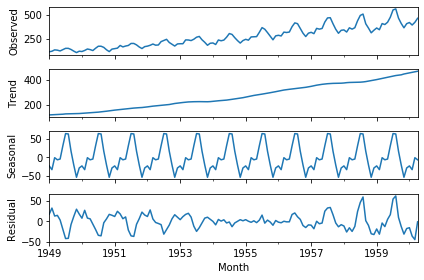

In [812]:
#to avoid NaNs an extra parameter freq can be passed.It will then use a Linear Least Squares to best approximate the values
"""model='additive means timeseries = trend + season + residual ' and since its the monthly data so freq=12"""
decomposition = seasonal_decompose(x=X_train, model='additive', freq=12, extrapolate_trend='freq') 
dec_plot = decomposition.plot()
dec_plot.show()
noise = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
adf_test(residual['#Passengers'], verbose=True) # check is data is stationary

For this problem we will go with Differencing but we will not do
over differenced series may still be stationary, which in turn will affect the model parameters.
right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick. but if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

Difference Order :-  1
test statistic:- -2.7486418545055353
p-value:- 0.06599263614969712
number of Lags Used:- 13
Number of Observations Used:- 121
1% levels:-	-3.485585145896754
5% levels:-	-2.885738566292665
10% levels:-	-2.5796759080663887


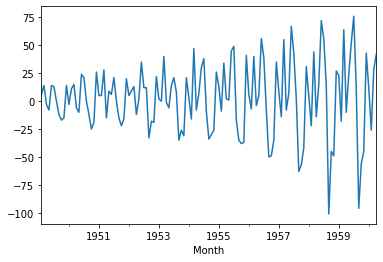

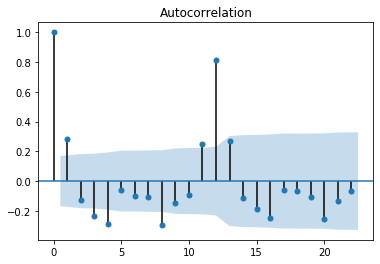

In [813]:
# we restrict our shift to 2 because after 2 shift ARIMA model doesn't supported
# first check for 1st order differencing
# here we will use 10% critical value check i.e 90% of confidence interval
cric_val_used1 = '10%'
data1, diff_order1 = get_stationary_data(X_train, 1, cric_val_used1) 
if data1 is not None :
    data1.plot()
    acf1 = plot_acf(data1)

time series reaches stationarity with One orders of differencing.
But looking at the autocorrelation plot for the 1nd differencing
the lag goes into the far negative zone fairly quick and since critical value we used is 10% means we have
90% confidence level that lets check for 2nd differencing

In [814]:
cric_val_used2 = '5%'
print('2nd order difference')
data2, diff_order2 = get_stationary_data(X_train, 2, cric_val_used2) 
if data2 is not None :
    data2.plot()
    acf2 = plot_acf(data2)

2nd order difference
Difference Order :-  1
test statistic:- -2.7486418545055353
p-value:- 0.06599263614969712
number of Lags Used:- 13
Number of Observations Used:- 121
1% levels:-	-3.485585145896754
5% levels:-	-2.885738566292665
10% levels:-	-2.5796759080663887
---------------------------------------------
Difference Order :-  2
test statistic:- -2.570249934790935
p-value:- 0.09930319950445732
number of Lags Used:- 11
Number of Observations Used:- 122
1% levels:-	-3.4851223522012855
5% levels:-	-2.88553750045158
10% levels:-	-2.5795685622144586
---------------------------------------------


There is not 2nd ordef difference data because it crosses last threshold of 10% critical value and still test statistics is greater then all critical value so we are going with 1nd order differencing even the series is not perfactly stationary.

In [815]:
data = data1
diff_order = diff_order1
cric_val_used =cric_val_used1

### Model Creation 
ARIMA depends on the parameters (p,d,q) :
    <li>p: - Number of AR (Auto-Regressive) terms(lags of dependent variable).
    <li>q: - Number of MA (Moving Average) terms(lagged forecast errors in prediction equation).
    <li>d: - Number of Differences (These are the number of nonseasonal differences).
<br/>value of d that is nothing but differencing order diff_order and rest other parameter p and q we can find by ACF and PACF data
<li><b>Autocorrelation Function (ACF): </b>It is a measure of the correlation between the the TS with a lagged version of
    <br/>itself. For example at lag 3, ACF would compare series at time instant t<sub>1</sub>…t<sub>2</sub> with series at instant t<sub>1-3</sub>…t<sub>2-3</sub>
<li><b>Partial Autocorrelation Function (PACF): </b>This measures the correlation between the TS with a lagged version of itself but after eliminating the variations
    <br>already explained by the intervening comparisons. Eg at lag 4, it will check the correlation but remove the effects already explained by lags 1 to 3.

Auto correlation can be calculated as function of lag(k)<br/>

r<sub>k</sub>=∑<sup>N−k</sup><sub>i=1</sub>(Y<sub>i</sub>−Y<sub>avg</sub>)(Y<sub>i+k</sub>−Y<sub>avg</sub>) <b>&#8725;</b> ∑<sup>N</sup><sub>i=1</sub>(Y<sub>i</sub>−Y<sub>avg</sub>)<sup>2</sup>


since we are checking for all the confidence level of critical value in ADF test(i.e 1%, 5%, 10% => 99% , 95% , 90%) confidence level we are taking maximum i.e 99% of confidence level to calculate confidence Bound<br/>

confidence bounds for the normal distribution N(0,1/L), whose standard deviation is 1/&radic;L<br/>

confidence bounds(&#916;) = 0 &#8723; sqrt(2)*erfinv(confidence_interval)<b> &#8725;</b> &radic;L

where :<br/> 
erfinv() =Inverse of <a href='https://en.wikipedia.org/wiki/Error_function'>error function</a>
<br/>L = number of sample
<br/>and confidence_interval can take value 0.99(99%), 0.95(95%) 0.90(90%) ...

Visualize the data 

In [816]:
# Implementing confidence bound formula
def get_confidence_bound(confidence_interval, n) :
    bound = np.sqrt(2)*erfinv(confidence_interval)/np.sqrt(n)
    return -bound, bound
lower_bound, upper_bound = get_confidence_bound(cric_val_to_CI[cric_val_used], len(data))

Plot ACF vs lag graph with confidence bound

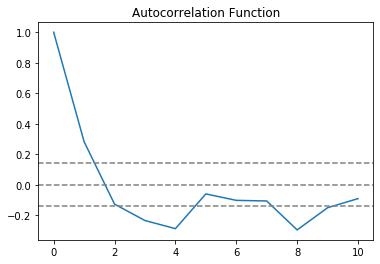

In [817]:
lag_acf = acf(data, nlags=10, fft=False)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=lower_bound, linestyle='--', color='gray')
plt.axhline(y=upper_bound, linestyle='--', color='gray')
plt.title('Autocorrelation Function')
plt.show()

Plot PACF vs lag graph with confidence bound

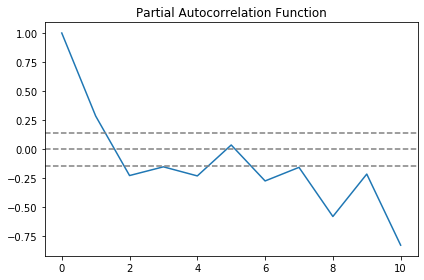

In [818]:
lag_pacf = pacf(data, nlags=10, method='ols')
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=lower_bound, linestyle='--', color='gray')
plt.axhline(y=upper_bound, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

we can see for Autocorrelation function graph cut upper confidence bound for first time at lag=2<br/>
therefore we will take <b>p=2</b><br/>
roughly we can see for Partial Autocorrelation function graph cut upper confidence bound for first time at lag=2<br/>
therefore we will take <b>q=2</b><br/>
and d is nothing but the difference order<br/>
short discription of <b>ARIMA</b> model :<br/>
pure <b>AR (Auto Regressive)</b> model where y<sub>t</sub> depends on its own lag mathematically:<br/>
<b> y<sub>t</sub> = &#945; + &#946;<sub>1</sub>y<sub>t-1</sub> + &#946;<sub>2</sub>y<sub>t-2</sub> + ... + &#946;<sub>p</sub>y<sub>t-p</sub> + &#949;<sub>t</sub><br/></b></br>
    where</br>
    <li>&#945; -> intercept</li>
    <li>&#946;s are the coefficients</li>
    <li>&#949; -> white noise</li>
pure <b>MA (Moving Average)</b> model where y<sub>t</sub> depends on the lagged forecast errors mathematically:<br/>
<b> y<sub>t</sub> = &#945; + &#966;<sub>1</sub>&#949;<sub>t-1</sub> + &#966;<sub>2</sub>&#949;<sub>t-2</sub> + ... + &#966;<sub>t-q</sub>&#949;<sub>t-q</sub></b></br>
    where</br>
    <li>&#945; -> intercept</li>
    <li>&#966;s parameters of model</li>
    <li>&#949; -> white noise error term</li>
 </br>
 <b>ARIMA mdel equation look like:</b> </br>
 <b> y<sub>t</sub> = &#945; + &#946;<sub>1</sub>y<sub>t-1</sub> + &#946;<sub>2</sub>y<sub>t-2</sub> + ... + &#946;<sub>p</sub>y<sub>t-p</sub> + &#949;<sub>t</sub> + &#966;<sub>1</sub>&#949;<sub>t-1</sub> + &#966;<sub>2</sub>&#949;<sub>t-2</sub> + ... + &#966;<sub>t-q</sub>&#949;<sub>t-q</sub></b></br>

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  135
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -622.164
Method:                       css-mle   S.D. of innovations             23.858
Date:                Mon, 11 Nov 2019   AIC                           1256.328
Time:                        16:52:10   BIC                           1273.760
Sample:                             1   HQIC                          1263.412
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4582      0.726      3.388      0.001       1.036       3.880
ar.L1.D.y      1.6529      0.036     46.090      0.000       1.583       1.723
ar.L2.D.y     -0.9162      0.035    -26.196      0.0

Text(0.5, 1.0, 'Prediction log Error vs lag')

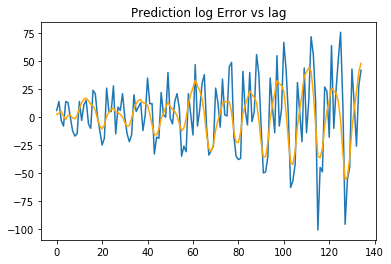

In [819]:
# fitting model
p=2
q=2
d=diff_order
model = ARIMA(X_train.values, order=(p, d, q), freq=None)  
results_ARIMA = model.fit(disp=True)  # disp=True to polulated output
plt.plot(data.values) # compare fitting parameter with d differenced order 
plt.plot(results_ARIMA.fittedvalues, color='orange')
print(results_ARIMA.summary())
plt.title('Prediction log Error vs lag')

The model AIC has low,
The P Values of the AR and MA terms have improved and are highly significant << 0.05.lets check the AR and MA coefficient.

In [820]:
print('Intercept', results_ARIMA.params[0])
print('AR Coefficient')
for i in range(0, len(results_ARIMA.arparams)) :
    print('t - {0} = {1}'.format(i+1, results_ARIMA.arparams[i]))
print('MA Coefficient')
for i in range(0, len(results_ARIMA.maparams)) :
    print('t - {0} = {1}'.format(i+1, results_ARIMA.maparams[i]))
rss = np.sum((results_ARIMA.fittedvalues-data.values[:split_index-diff_order])**2)
print('Residual Sum of square ', rss)

Intercept 2.4581557245901
AR Coefficient
t - 1 = 1.6529128654712502
t - 2 = -0.9161944067145235
MA Coefficient
t - 1 = -1.8474883968677664
t - 2 = 0.9401744074020745
Residual Sum of square  77416.13278796208


Lets plot the original vs forcast graph

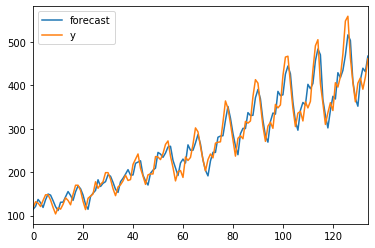

In [821]:
s=results_ARIMA.plot_predict(dynamic=False)

plot residuals to ensure there are no patterns i.e look for constant mean and variance

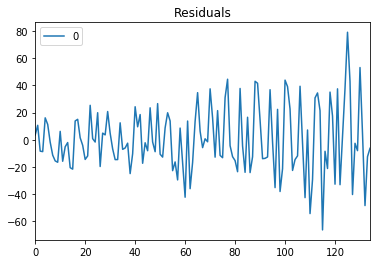

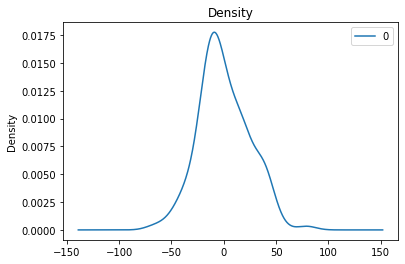

In [822]:
residuals = pd.DataFrame(results_ARIMA.resid)
temp=residuals.plot(title='Residuals')
temp=residuals.plot(kind='kde', title='Density')

residual errors seem fine with near zero mean and some what uniform variance

Lets forcast future point prediction

In [823]:
num_of_predition = len(X_test)
_alpha = 1 - cric_val_to_CI[cric_val_used] # e.g for 90% confidence level alpha = (1 - 0.90) = 0.10
# forecast() return predicted array, standerd error and confidence interval
prediction, std_err, conf_int = results_ARIMA.forecast(steps=num_of_predition, alpha=_alpha)

Let's visualize the train and test data together with confidence interval 

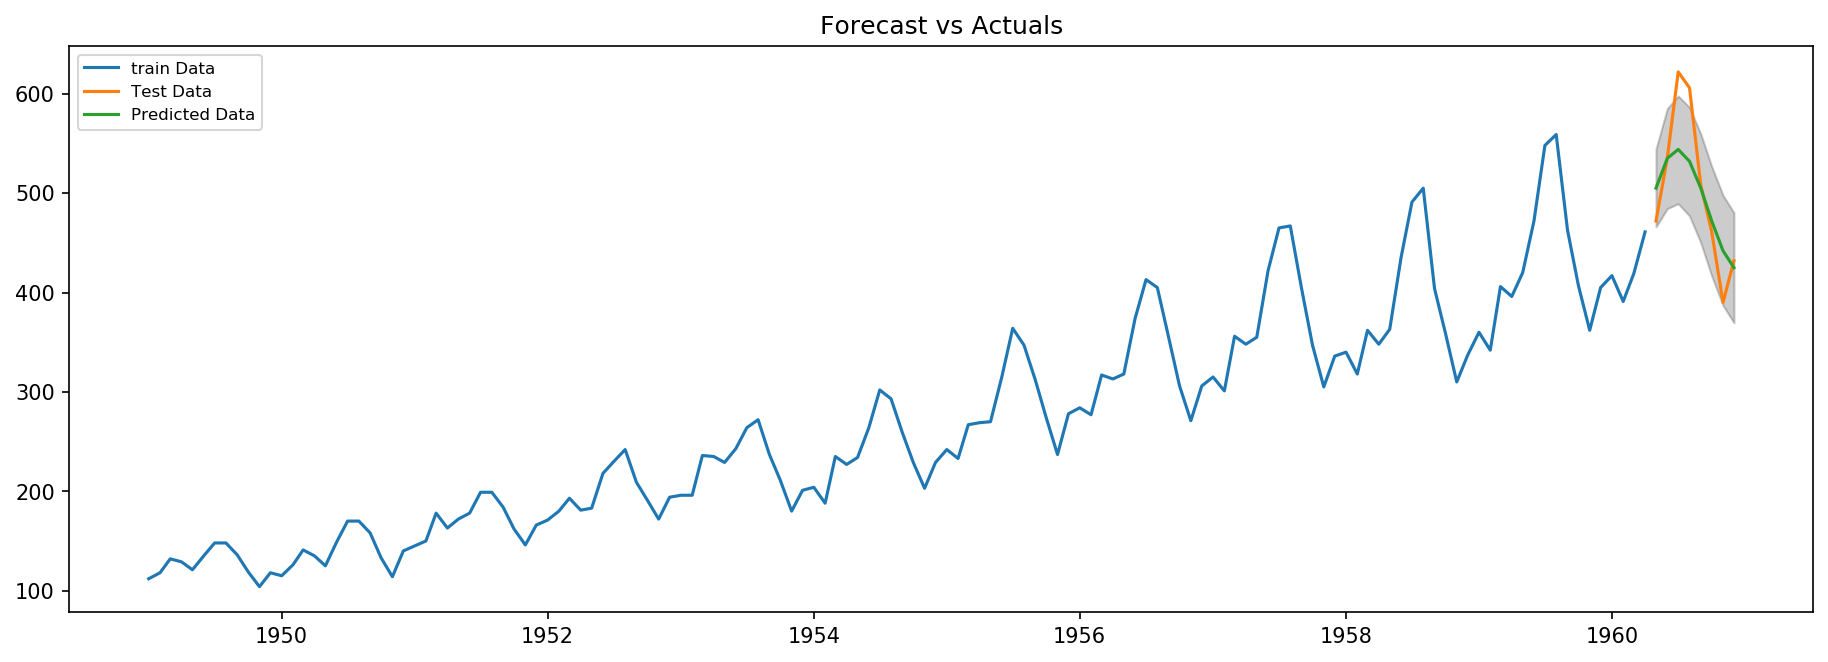

In [824]:
fc_series = pd.Series(np.rint(prediction), index=X_test.index)
lower_bound = pd.Series(conf_int[:, 0], index=X_test.index)
upper_bound = pd.Series(conf_int[:, 1], index=X_test.index)

# Plot
plt.figure(figsize=(15,5), dpi=150)
plt.plot(X_train, label='train Data')
plt.plot(X_test, label='Test Data')
plt.plot(fc_series, label='Predicted Data')
plt.fill_between(X_test.index, lower_bound, upper_bound, 
                 color='black', alpha=.20)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [825]:
print('Root mean square error will be of test data')
print(mean_squared_error(X_test.values.reshape(-1), prediction)**0.5)

Root mean square error will be of test data
44.29356985922285


Now we will define a function which take past data, order tuple, alpha value and number of predictor so that we can predict in continuous fashion

In [826]:
def predict_next(history, _order, p_alpha, number_of_prediction=1):
    model = ARIMA(history.values, order=_order, freq=None) 
    results_ARIMA = model.fit(start_ar_lags = 2*max(_order[0], _order[2]), solver='bfgs', disp=False)  # use different solver to supress the HessianInversionWarning
    prediction, std_err, conf_int = results_ARIMA.forecast(steps=number_of_prediction, alpha=p_alpha)
    # creating index after last time stramp
    index_new = pd.DatetimeIndex(pd.period_range(history.index[-1], periods=number_of_prediction+1, freq='M').to_timestamp())
    pred_df = pd.DataFrame({history.columns[0]: prediction}, index=index_new[1:]) #ignoring 1st inde because already present in history
    bound_df =pd.DataFrame({'Lower_bound': conf_int[:, 0], 'Upper_bound': conf_int[:, 1]}, index=index_new[1:])
    return pred_df, std_err, bound_df

Update method to get latest data at t-1, t-2 ... every time from prediction

In [827]:
def update_history(history, data, window_size, with_drop=False):
    history = history.append(data, ignore_index=False, verify_integrity=True)
    if with_drop : # if with_drop is true then drop the previous observation of window_size length
        history.drop(history.iloc[:window_size, :].index, inplace=True, axis=0)
    return history

Now continuous prediction after test data observation

In [828]:
history = X_train
_order= (p, d, q)
alpha = _alpha
num_of_prediction = 1 # number of predicted data give at each iteration
# add X_test data to train data for further prediction
predicted_df = None
history = update_history(history, X_test, num_of_prediction) # window size same as number of predicted value we want
# loop to get predicted value iteratively :
for i in range(0, 10) : # say for next 10 prediction change this value to get n number f prediction
    pred, err, bound = predict_next(history, _order, alpha, num_of_prediction)
    history = update_history(history, pred, num_of_prediction, False)
    if predicted_df is None :
        predicted_df = pd.concat([pred, bound], axis=1)
    else :
        predicted_df = predicted_df.append(pd.concat([pred, bound], axis=1), ignore_index=False, verify_integrity=True)
predicted_df = np.rint(predicted_df) # round off since number of passengers should not in float
print(predicted_df)

            #Passengers  Lower_bound  Upper_bound
1961-01-01        433.0        392.0        474.0
1961-02-01        453.0        413.0        494.0
1961-03-01        483.0        443.0        523.0
1961-04-01        516.0        475.0        556.0
1961-05-01        543.0        503.0        583.0
1961-06-01        559.0        519.0        599.0
1961-07-01        561.0        521.0        600.0
1961-08-01        550.0        510.0        590.0
1961-09-01        532.0        492.0        571.0
1961-10-01        512.0        472.0        551.0


This is basic ARIMA model for time series data. We can model this better by ensembling with Deep Neural Nework Model like C-NN, R-NN, LSTM.